In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.fft as fft

In [2]:
electrode_names = [
    "FP1", "FPz", "FP2", "AFp1", "AFPz", "AFp2", "AF7", "AF3", "AF4", "AF8",
    "AFF5h", "AFF1h", "AFF2h", "AFF6h", "F9", "F7", "F5", "F3", "F1", "Fz",
    "F2", "F4", "F6", "F8", "F10", "FFT9h", "FFT7h", "FFC5h", "FFC3h", "FFC1h",
    "FFC2h", "FFC4h", "FFC6h", "FFT8h", "FFT10h", "FT9", "FT7", "FC5", "FC3",
    "FC1", "FCz", "FC2", "FC4", "FC6", "FT8", "FT10", "FTT9h", "FTT7h", "FCC5h",
    "FCC3h", "FCC1h", "FCC2h", "FCC4h", "FCC6h", "FTT8h", "FTT10h", "T7", "C5",
    "C3", "C1", "Cz", "C2", "C4", "C6", "T8", "TTP7h", "CCP5h", "CCP3h", "CCP1h",
    "CCP2h", "CCP4h", "CCP6h", "TTP8h", "TP9", "TP7", "CP5", "CP3", "Cpz", "CP4",
    "CP6", "TP8", "TP10", "TPP9h", "TPP7h", "CPP5h", "CPP3h", "CPP1h", "CPP2h",
    "CPP4h", "CPP6h", "TPP8h", "TPP10h", "P9", "P7", "P5", "P3", "P1", "Pz", "P2",
    "P4", "P6", "P8", "P10", "PPO9h", "PPO5h", "PPO1h", "PPO2h", "PPO6h", "PPO10h",
    "PO9", "PO7", "PO3", "POz", "PO4", "PO8", "PO10", "POO9h", "POO1", "POO2",
    "POO10h", "O1", "Oz", "O2", "OI1h", "OI2h", "I1", "Iz", "I2"
]

num_electrodes = len(electrode_names)

num_electrodes
NUM_CHANNELS_TO_LOAD = 128
DATA_SIZE = 60_000
SIGNAL_LENGTH = 167

In [3]:
labels = np.zeros(DATA_SIZE, dtype=int)
data = np.zeros((DATA_SIZE, NUM_CHANNELS_TO_LOAD, SIGNAL_LENGTH))

def data_selection():
    class_means = np.zeros((11, 128, 167))
    for i in tqdm(range(-1, 10)):
        class_means[i+1] = np.mean(data[labels == i], axis=0)
    z = np.zeros(DATA_SIZE)
    for i in tqdm(range(DATA_SIZE)):
        j = labels[i]
        x = data[i]
        z[i] = np.corrcoef(x, class_means[j])[0][1]
    return z

def load_channel(channel: int, cz: int):
    i = 0
    csize = cz
    for chunk in tqdm(pd.read_csv('/kaggle/input/processed-train/processed_train.csv', chunksize=cz)):
        labels[i*csize:(i+1)*csize] = chunk['label'].to_numpy()
        data[i*csize:(i+1)*csize] = chunk.iloc[0:csize, :-2].to_numpy().reshape((csize,NUM_CHANNELS_TO_LOAD,SIGNAL_LENGTH))[:,channel:channel+NUM_CHANNELS_TO_LOAD,:].reshape((csize, NUM_CHANNELS_TO_LOAD, SIGNAL_LENGTH))
        i = i + 1
        if i == (DATA_SIZE / csize):
            break
    
        

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from multiprocessing import Pool, Pipe
from itertools import combinations

n_neighbors = 13

def do_work(i):
    nums = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    result = np.zeros((11,11))
    for e, x in enumerate(combinations(nums, 2)):
        j, l = x
        y = labels[(labels == j) | (labels == l)]
        d = data[(labels == j) | (labels == l)]
        X_train, X_test, y_train, y_test = train_test_split(d[:,i,:], y, test_size=0.2, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        a = accuracy_score(y_test, y_pred)
        result[j, l] = a
        result[l, j] = a
    r = result.flatten()
    r = r[r != 0]
    print("i: " + str(i) + ": " + str(np.mean(r)))
    return result


def classify_all_nums():
    with Pool() as pool:
        accuracies = pool.map(do_work, range(NUM_CHANNELS_TO_LOAD))
    return accuracies



In [5]:
load_channel(0, 1000)

59it [12:24, 12.62s/it]


In [6]:
z = data_selection()
data = data[np.abs(z) >= 0.2]
print(data.shape)
labels = labels[np.abs(z) >= 0.2]


  0%|          | 0/60000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 60000/60000 [02:27<00:00, 406.88it/s]


(29074, 128, 167)


In [7]:
a = classify_all_nums()

i: 16: 0.5040442441367912
i: 0: 0.503866782118304
i: 24: 0.5061754317530471
i: 8: 0.5085098413131376
i: 17: 0.503651039387069
i: 1: 0.5071616555563847
i: 25: 0.5027999735282958
i: 9: 0.5012001894092752
i: 18: 0.4993141758263392
i: 2: 0.5040239100236975
i: 26: 0.5048589719475007
i: 10: 0.5012994391560421
i: 19: 0.5047481732157824
i: 3: 0.5032617716608025
i: 27: 0.5010075484378652
i: 11: 0.5008428123019305
i: 20: 0.504930491364898
i: 4: 0.5011950765816217
i: 28: 0.5032372931276542
i: 12: 0.504863567546895
i: 21: 0.4972600263527084
i: 5: 0.500676597015958
i: 29: 0.4997887155780087
i: 13: 0.5074991738463707
i: 22: 0.4998798926495276
i: 6: 0.4998678393058929
i: 30: 0.49971236277209985
i: 14: 0.49529864971407705
i: 23: 0.5073369010489739
i: 7: 0.5070265535607354
i: 31: 0.5005688159451809
i: 15: 0.5032227125347095
i: 32: 0.5031797118199779
i: 48: 0.5038722538804499
i: 40: 0.49715054988621826
i: 56: 0.49903054944997083
i: 33: 0.5017511119089357
i: 49: 0.49990487396453975
i: 41: 0.4993748348505

/tmp/ipykernel_18/3281820150.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  v = cm.get_cmap('viridis', 5)


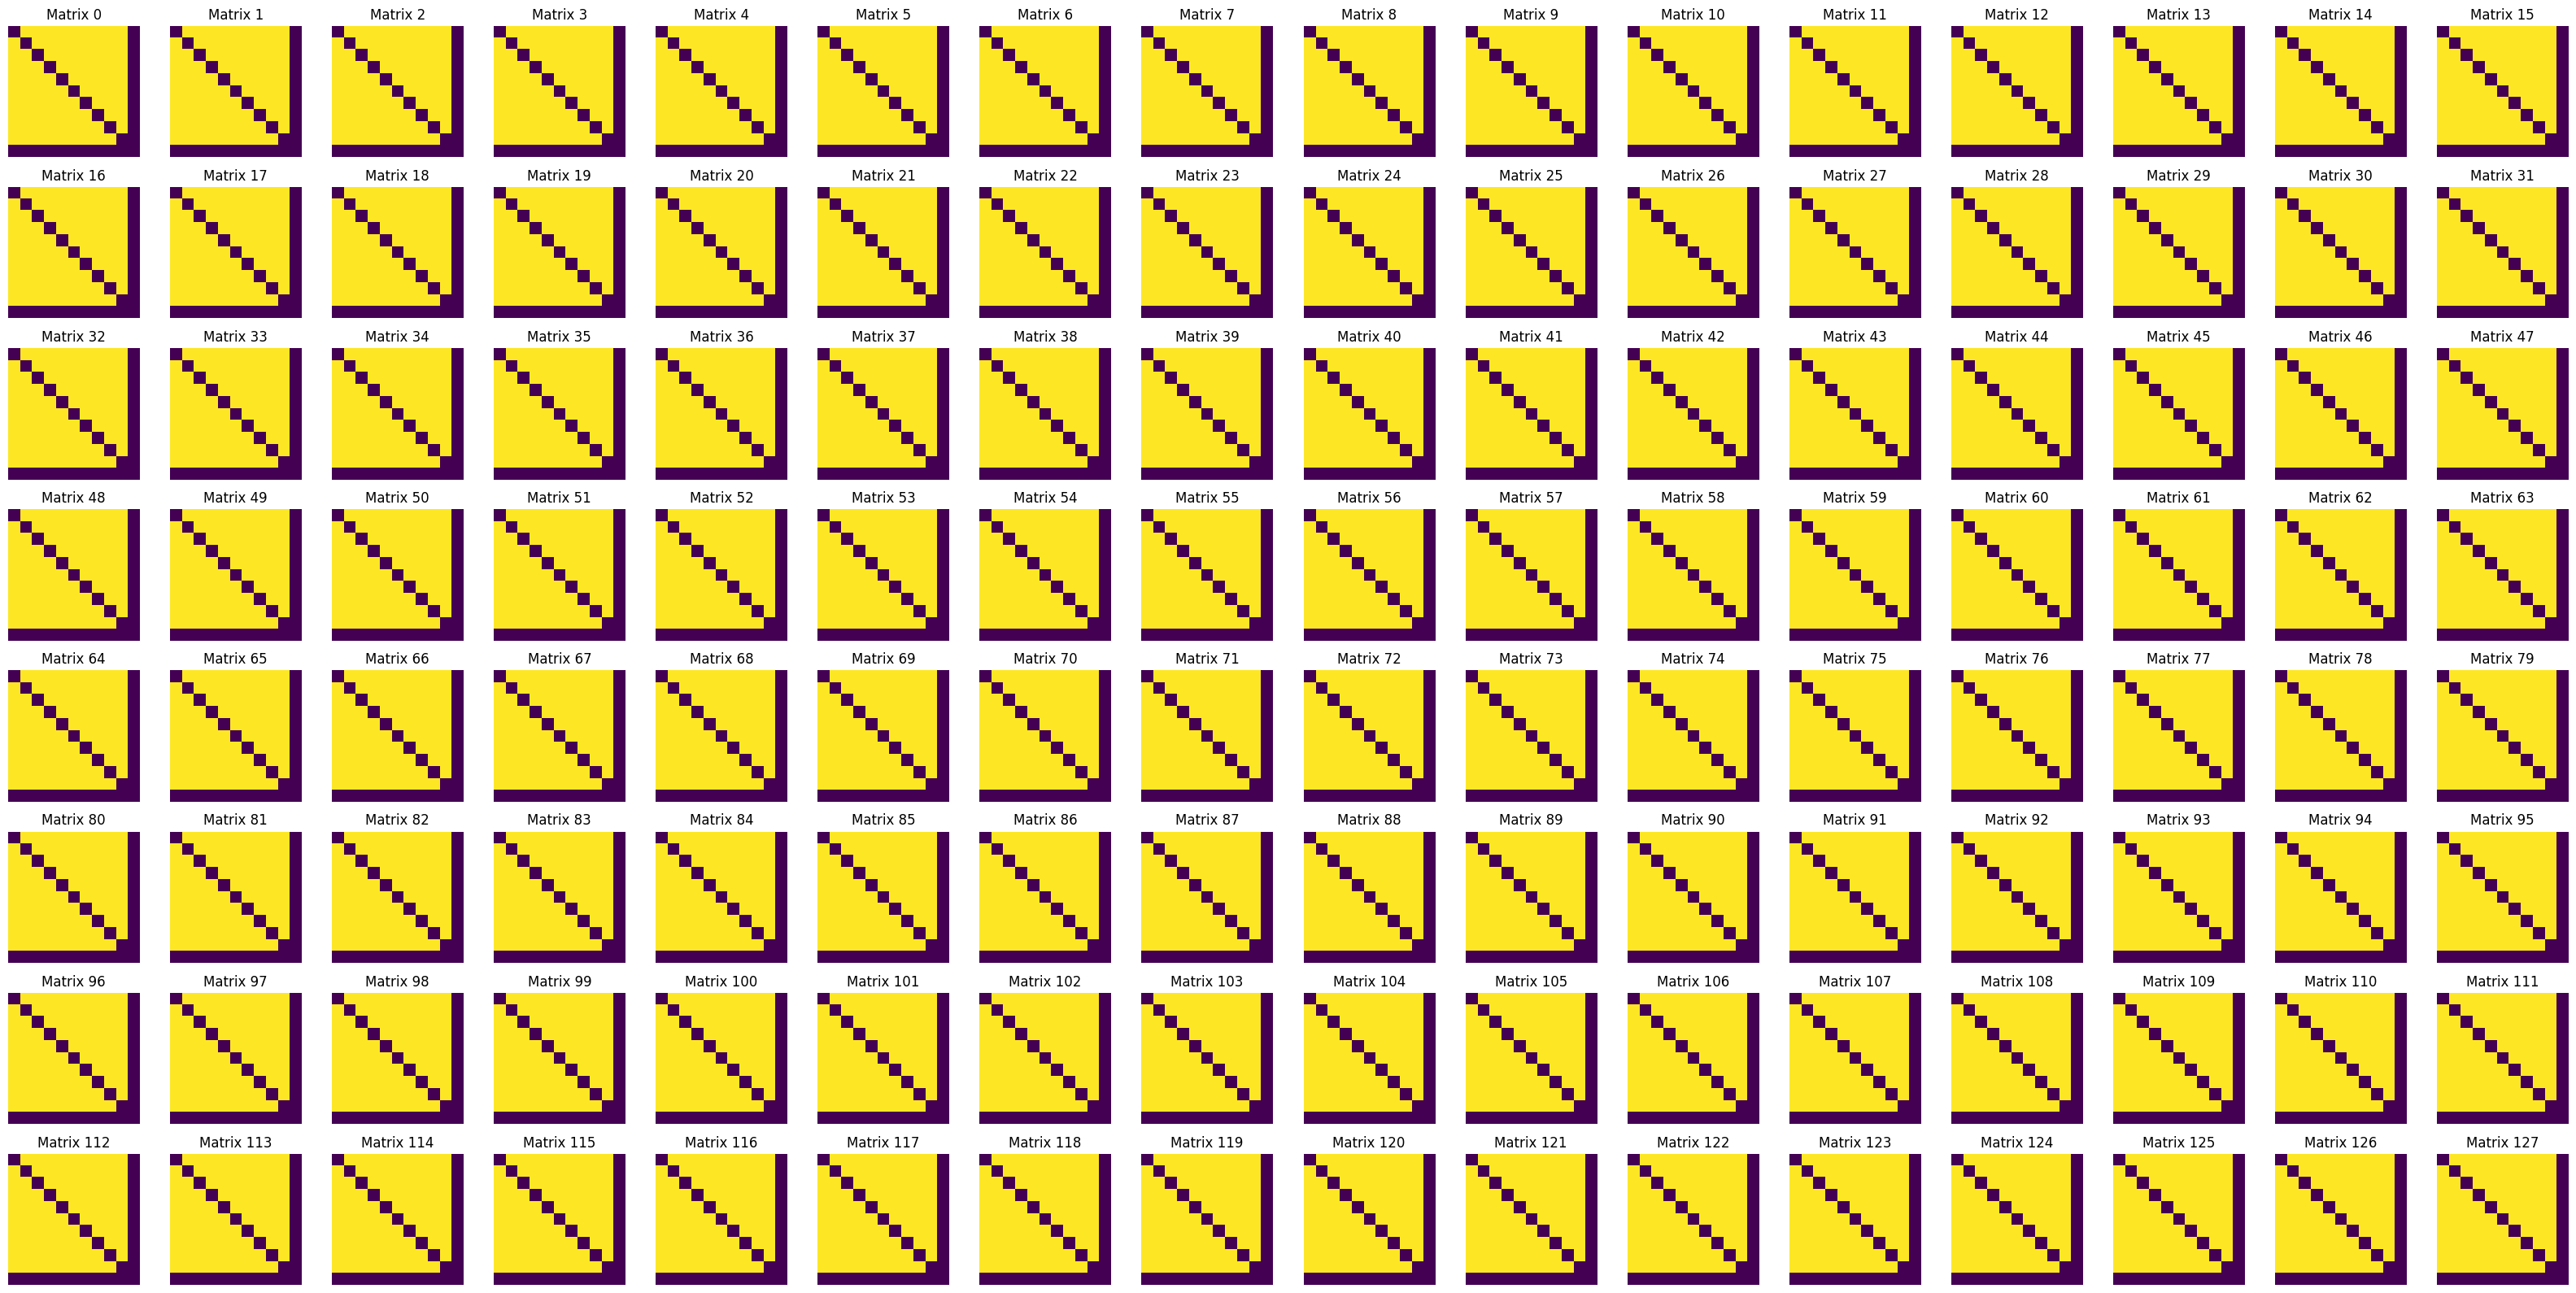

In [8]:
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

a = np.array(a)
num_matrices = a.shape[0]
rows = 8
cols = num_matrices // rows if num_matrices % rows == 0 else num_matrices // rows + 1  # Number of columns

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

v = cm.get_cmap('viridis', 5)
for i in range(num_matrices):
    row = i // cols
    col = i % cols
    
    axes[row, col].imshow(a[i], cmap=v)
    axes[row, col].set_title(f'Matrix {i}')
    axes[row, col].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



In [9]:
best = []
for i in range(10):
    for j in range(10):
        if i == j:
            break
        max = np.max(a[:,i,j])
        index = np.argmax(a[:,i,j])
        best.append(index)
        print(f"Max accuracy for {i} and {j} is {max} at channel {index}")
print(len(best))
bset = set(best)
print(len(bset))
print(bset)

Max accuracy for 1 and 0 is 0.5533822330888346 at channel 16
Max accuracy for 2 and 0 is 0.5493079584775087 at channel 47
Max accuracy for 2 and 1 is 0.5437448896156991 at channel 84
Max accuracy for 3 and 0 is 0.5317324185248714 at channel 107
Max accuracy for 3 and 1 is 0.5445705024311183 at channel 42
Max accuracy for 3 and 2 is 0.53184165232358 at channel 28
Max accuracy for 4 and 0 is 0.5304347826086957 at channel 108
Max accuracy for 4 and 1 is 0.5439605587510271 at channel 36
Max accuracy for 4 and 2 is 0.5388646288209606 at channel 67
Max accuracy for 4 and 3 is 0.5363321799307958 at channel 91
Max accuracy for 5 and 0 is 0.5398388540734109 at channel 69
Max accuracy for 5 and 1 is 0.5464527027027027 at channel 100
Max accuracy for 5 and 2 is 0.5359712230215827 at channel 33
Max accuracy for 5 and 3 is 0.5360641139804097 at channel 23
Max accuracy for 5 and 4 is 0.5415913200723327 at channel 72
Max accuracy for 6 and 0 is 0.5410544511668107 at channel 17
Max accuracy for 6 and 

In [10]:
# get the 16 channels with the highest accuracy
channels = []
temp = []
for t in a:
    temp.append(np.mean(t))

temp = np.array(temp)
    
for i in range(16):
    m = np.max(temp)
    index = np.argmax(temp)
    channels.append(index)
    temp = temp[temp != m]
print(channels)

[8, 12, 21, 1, 92, 6, 29, 19, 110, 39, 98, 73, 72, 30, 66, 80]


In [11]:
for c in channels:
    best.append(c)
bset = set(best)
print(len(bset))
print(bset)

56
{1, 2, 3, 5, 6, 7, 8, 10, 12, 13, 16, 17, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30, 33, 34, 36, 37, 38, 39, 41, 42, 46, 47, 50, 54, 57, 58, 66, 67, 69, 70, 71, 72, 73, 80, 81, 83, 84, 91, 92, 97, 98, 100, 107, 108, 110, 123}


In [12]:
for c in combinations([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 2):
    x, y = c
    i = labels[labels==x].shape[0]
    j = labels[labels==y].shape[0]
    print(f"Class {x} has {i} samples, class {y} has {j} samples")
    print(f"Ratio is {i/j}")

Class 0 has 2899 samples, class 1 has 3236 samples
Ratio is 0.8958590852904821
Class 0 has 2899 samples, class 2 has 2877 samples
Ratio is 1.0076468543621828
Class 0 has 2899 samples, class 3 has 2931 samples
Ratio is 0.9890822244967588
Class 0 has 2899 samples, class 4 has 2847 samples
Ratio is 1.0182648401826484
Class 0 has 2899 samples, class 5 has 2682 samples
Ratio is 1.080909768829232
Class 0 has 2899 samples, class 6 has 2883 samples
Ratio is 1.0055497745404094
Class 0 has 2899 samples, class 7 has 3063 samples
Ratio is 0.9464577211883775
Class 0 has 2899 samples, class 8 has 2757 samples
Ratio is 1.0515052593398622
Class 0 has 2899 samples, class 9 has 2898 samples
Ratio is 1.0003450655624568
Class 1 has 3236 samples, class 2 has 2877 samples
Ratio is 1.1247827598192561
Class 1 has 3236 samples, class 3 has 2931 samples
Ratio is 1.1040600477652678
Class 1 has 3236 samples, class 4 has 2847 samples
Ratio is 1.1366350544432737
Class 1 has 3236 samples, class 5 has 2682 samples
Ra